In [1]:
import networkx as nx
import numpy as np

# Read raw graph and Convert to MutliDiGraph object

In [2]:
in_graph = 'datasets/sourcecred/makerDao_graph.json'
import json 

with open(in_graph) as f:   
        cred = json.load(f) 

In [3]:
min_t = cred[1]['graphJSON'][1]['edges'][0]['timestampMs']
max_t = cred[1]['graphJSON'][1]['edges'][0]['timestampMs']
for v in cred[1]['graphJSON'][1]['edges']:
    min_t = min(v['timestampMs'], min_t)
    max_t = max(v['timestampMs'], max_t)

print(min_t, max_t)

KeyError: 1

In [4]:
G = nx.MultiDiGraph()
id_to_user = {}

def node_type(desc):
    if '❤️' in desc:
        return 'like'
    elif "#" in desc and 'on' in desc: 
        return 'post'
    elif "https://forum.makerdao.com/t/" in desc:
        return 'topic'
    elif 'https://forum.makerdao.com/u/' in desc:
        return 'user'
    else:
        return None

# Add nodes 
for v in cred[1]['graphJSON'][1]['nodes']:
    i = v['index']
    time = v['timestampMs']
    type = node_type(v['description'])
    if type == 'user':
        id_to_user[i] = v['description'].split('[')[-1].split(']')[0]
    if not type:
        print('Unknown Type:', v)
        break
    G.add_node(i, time=time, type=type)

def edge_type(address):
    if 'likes' in address:
        return 'likes'
    if 'replyTo' in address:
        return 'replyTo'
    if 'references' in address and 'topic' in address:
        return 'refTopic'
    if 'references' in address and 'post' in address:
        return 'refPost'
    if 'references' in address and 'user' in address:
        return 'refUser'
    if 'topicContainsPost' in address:
        return 'isPart'
    if 'topicHasLikedPost' in address:
        return 'isPart'
    if 'authors' in address and 'post' in address:
        return 'createdBy'
    if 'authors' in address and 'topic' in address:
        return 'createdBy'
    if 'createsLike' in address:
        return 'createsLike'    
    return None

def weights(e_type: str):
    if e_type == 'likes':
        return 1
    elif e_type == 'replyTo':
        return 0.5
    elif e_type == 'refTopic':
        return 0.5
    elif e_type == 'refPost':
        return 0.5
    elif e_type == 'refUser':
        return 0.25
    elif e_type == 'isPart':
        return 0.125
    elif e_type == 'createdBy':
        return 1
    elif e_type == 'createsLike':
        return 1
    else:
        return 0

to_be_reverted = {'createdBy', 'isPart'}

# Add edges 
for v in cred[1]['graphJSON'][1]['edges']:
    s = v['srcIndex']
    d = v['dstIndex']
    time = v['timestampMs']
    type = edge_type(v['address'])
    weight = weights(type)
    if not type:
        print('Unknown Type:', v)
        break
    if type in to_be_reverted:
        G.add_edge(d, s, time=time, type=type, weight=weight)
    else:
        G.add_edge(s, d, time=time, type=type, weight=weight)


In [5]:
# 1561406027194 1653523898093
for k,v in dict(G.nodes(data=True)).items():
    if 'type' not in v:
        for _,_, d in  G.in_edges(k, data=True):
            if 'refTopic' == d['type']:
                G.add_node(k, type='topic')
            elif 'refUser' == d['type']:
                G.add_node(k, type='user') 
            elif 'refPost' == d['type']:
                G.add_node(k, type='post') 


In [6]:
from networkx.readwrite import json_graph
import json

d = json_graph.node_link_data(G)
with open('datasets/sourcecred/makerDao_graph.json', 'w') as outfile1:
    outfile1.write(json.dumps(d))

## Convert to Temporal Work Graph 

In [7]:
users = {k for k,v in dict(G.nodes(data=True)).items() if v['type'] == 'user'}
author = dict()
for u in users:
    for s,t, data in G.out_edges(u, data=True):
        author[t] = s 
    for s,t, data in G.in_edges(u, data=True):
        if data['type'] == 'createdBy':
            author[s] = u


In [8]:
delta = 7 * 24 * 60 * 60 * 1000
l = (max_t - min_t) // delta + 1

In [13]:
G_t = [nx.DiGraph() for _ in range(l)]

for i in range(l):
    time = min_t + i * delta
    for k,v in G.nodes(data=True):
        if 'user' not in v['type']:
            s_u = author.get(k)
            if not s_u:
                continue
            for s,t,data in G.out_edges(k, data=True):
                if data['time'] >= time and data['time'] < time + delta:
                    t_u = t if t in users else author.get(t)
                    if not t_u or s_u == t_u:
                        continue
                    w = G_t[i][s_u][t_u]['weight'] if (s_u,t_u) in G_t[i].edges() else 0 
                    G_t[i].add_edge(s_u, t_u, weight= w + data['weight'])

In [10]:
max_n = 0
max_e = 0
max_i = 0 

for i in range(l):
    if G_t[i].number_of_nodes() > max_n:
        max_n = G_t[i].number_of_nodes()
        max_e = G_t[i].number_of_edges()
        max_i = i

print(max_n, max_e, max_i)

291 1528 149


In [14]:
from networkx.readwrite import json_graph
import json

for i in range(l):
    d = json_graph.node_link_data(G_t[i])
    with open('datasets/sourcecred/makerDao_work/wg'+str(i)+'.json', 'w') as outfile1:
        outfile1.write(json.dumps(d))
with open('datasets/sourcecred/makerDao_work/timeperiod.txt', 'w') as outfile1:
        outfile1.write(str(min_t) + ',' + str(max_t) + ',' + str(delta))

In [12]:
with open('datasets/sourcecred/md_users.txt', 'w') as outfile1:
    for i,u in id_to_user.items():
        outfile1.write(str(i) + ',' + u + '\n')

## Visualizations of the dataset

In [9]:
from networkx.readwrite import json_graph
import json

l = 153
G_t  = []

for i in range(l):
    with open('datasets/sourcecred/makerDao_work/wg'+str(i)+'.json', 'r') as f:
        d = json.loads(f.read())
        G = json_graph.node_link_graph(d)
        # Normalize the weights to [1, inf]
        for e in list(G.edges()):
            G[e[0]][e[1]]['weight'] *= 4
        G_t.append(G)


In [10]:
all_nodes = set()
all_edges = set()

max_u = 0
max_e = 0
w = 0
i = 0

for G in G_t:
    all_nodes.update(G.nodes())
    all_edges.update(G.edges())

    if len(G.nodes) > max_u:
        w = i
        max_u = len(G.nodes())
        max_e = len(G.edges())
    i+=1


In [11]:
len(all_edges), len(all_nodes)

(35853, 2057)

In [12]:
max_u, max_e, w

(291, 1528, 149)

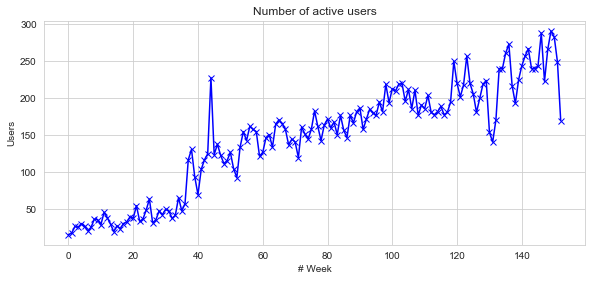

In [14]:
import matplotlib.pyplot as plt

target_user = 141360
n_nodes = [G_t[i].number_of_nodes() for i in range(l)]

fig = plt.figure("Degree of a random graph", figsize=(16, 9))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(range(l), n_nodes, "b-", marker="x")
ax1.set_title("Number of active users")
ax1.set_ylabel("Users")
ax1.set_xlabel("# Week")

fig.tight_layout()
plt.show()

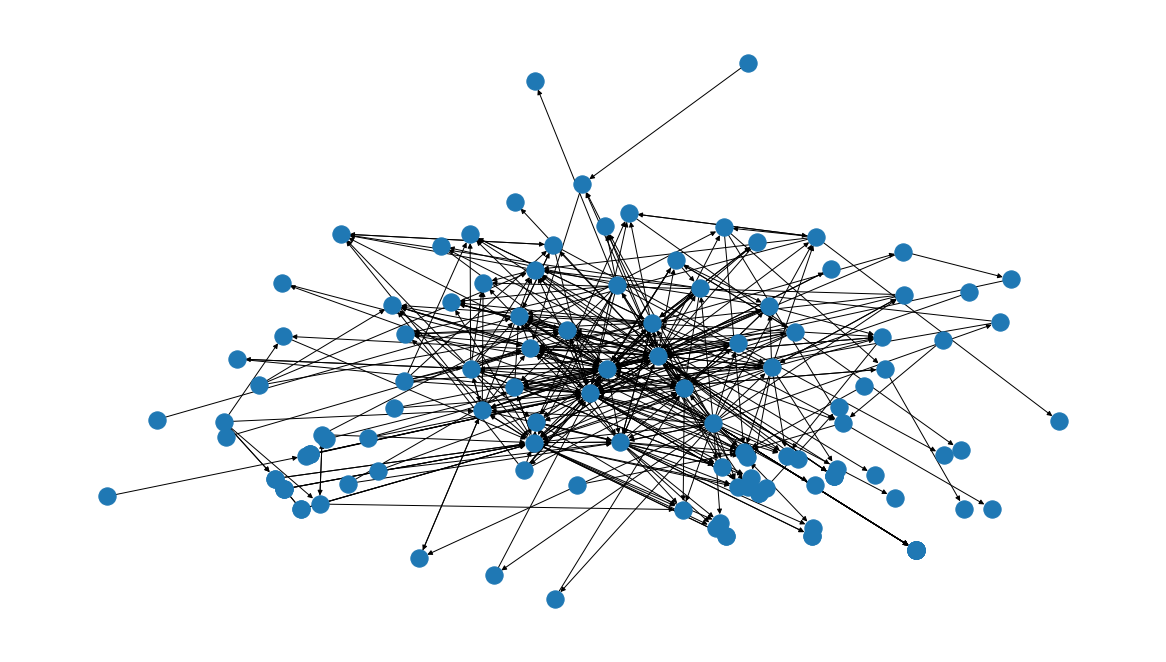

In [311]:
fig = plt.figure("Degree of a random graph", figsize=(16, 9))
nx.draw_kamada_kawai(G_t[50], with_labels=False)

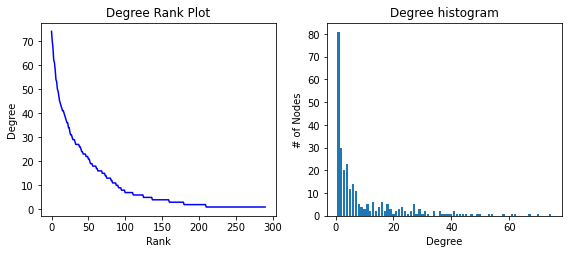

In [314]:
degree_sequence = sorted((d for n, d in G_t[149].degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-",)
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [16]:
id_to_user[140860]

'@MicahZoltu'

In [21]:
G_t[0].in_degree(140860, weight='weight')

3.625

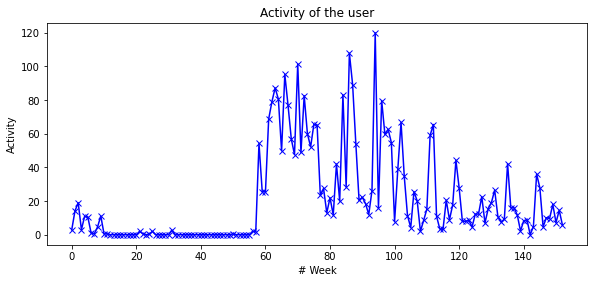

In [26]:
target_user = 141957
n_nodes = [G_t[i].in_degree(target_user, weight='weight') + G_t[i].out_degree(target_user, 'weight') if target_user in G_t[i] else 0 for i in range(l)]

fig = plt.figure("Degree of a random graph", figsize=(16, 9))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(range(l), n_nodes, "b-", marker="x")
ax1.set_title("Activity of the user")
ax1.set_ylabel("Activity")
ax1.set_xlabel("# Week")

fig.tight_layout()
plt.show()

In [335]:
for i,v in id_to_user.items():
    if 'Planet' in v:
        print(i, v)

140957 @Planet_X


'@mrabino1'